## Import Libraries

In [1]:
import pyspark.pandas as ps
import pandas as pd
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from spacy.lang.en.stop_words import STOP_WORDS
from pyspark.sql import SparkSession
import seaborn as sns
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType, MapType

# Load spaCy's pre-trained model for English
nlp = spacy.load('en_core_web_md')
spark = SparkSession.builder \
            .master('local[*]') \
            .config("spark.driver.memory", "12g") \
            .config("spark.executor.memory", "12g") \
            .config("spark.memory.offHeap.enabled", "true") \
            .config("spark.memory.offHeap.size","24g") \
            .config("spark.driver.maxResultSize", "24g") \
            .getOrCreate()
categories = ['AMAZON_FASHION', 'All_Beauty', 'Appliances' , 'Arts_Crafts_and_Sewing' , 'Automotive', 'Books', 'CDs_and_Vinyl', 'Cell_Phones_and_Accessories', 'Clothing_Shoes_and_Jewelry', 'Digital_Music', 'Electronics', 'Gift_Cards', 'Grocery_and_Gourmet_Food', 'Home_and_Kitchen', 'Industrial_and_Scientific', 'Kindle_Store', 'Luxury_Beauty', 'Magazine_Subscriptions', 'Movies_and_TV', 'Musical_Instruments', 'Office_Products', 'Patio_Lawn_and_Garden', 'Pet_Supplies', 'Prime_Pantry', 'Software', 'Sports_and_Outdoors', 'Tools_and_Home_Improvement', 'Toys_and_Games', 'Video_Games']
#categories = ['AMAZON_FASHION', 'All_Beauty', 'Appliances' , 'Arts_Crafts_and_Sewing']

/home/allorenz/.cache/pypoetry/virtualenvs/tu-dopp-ws23-U-ympmBJ-py3.11/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/31 15:19:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Helper Functions 
- Lemmatazation and Stop Word Removal 
- Word Count

In [2]:
def lemmatize_text_spacy(text):
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(lemmatized_words)


def get_word_counts(text):
    doc = nlp(text)
    word_counter = Counter([token.text for token in doc if token.pos_ in {'NOUN', 'VERB', 'ADJ'}])
    return dict(word_counter)

# transform to udf method
lemmatize_udf = udf(lemmatize_text_spacy, StringType())
get_word_counts_udf = udf(get_word_counts, MapType(StringType(), StringType()))

Load reviews and retrieve word counts

In [3]:
def get_word_counts_by_category(min_per_cat = 1000, frac = 0.0001, verbose = False):
    word_counts_by_category = {}

    for category in categories:
        word_counter = Counter()

        if verbose:
            print(f"Currently subsampling category {category} ...")
        
        # subsample based on star ratings
        spark_data = spark.read.parquet(f'/data/{category}.parquet')
        spark_data = spark_data[["reviewText", "overall", "vote"]].dropna()
        frac = max(frac, min_per_cat / spark_data.count())
        fractions = {stars: frac for stars in range(1, 6)}
        df_spark = spark_data.sampleBy('overall', fractions, seed=42)
        
        # Filter out rows where "reviewText" is null
        df_spark = df_spark.filter(df_spark["reviewText"].isNotNull())
        
        # Lemmatize and Stop words removal
        df_spark = df_spark.withColumn("reviewText", lemmatize_udf("reviewText"))
        
        # Word Counts
        df_spark = df_spark.withColumn("wordCounts", get_word_counts_udf("reviewText"))
        df_spark_filtered = df_spark.filter(df_spark["wordCounts"].isNotNull())
        
        # Collect the results into a local Python list
        word_counts_list = df_spark_filtered.select("wordCounts").collect()

        # Update the entity_label_counter using the collected list
        for row in word_counts_list:
            if row['wordCounts'] is not None:
                # Convert values to integers before updating the Counter
                word_counts = {key: int(value) for key, value in row['wordCounts'].items()}
                word_counter.update(word_counts)


        word_counts_by_category[category] = word_counter

    return word_counts_by_category

word_counts_by_category = get_word_counts_by_category(1000, 0.01)


24/01/31 15:19:57 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


## Wordcloud
Our assumption is that nouns, verbs, and adjectives might carry and reflect the most information about certain aspects of a product. A Wordcloud for each categoryy of top used part-of-speech is created to derive the most important aspects in each category.

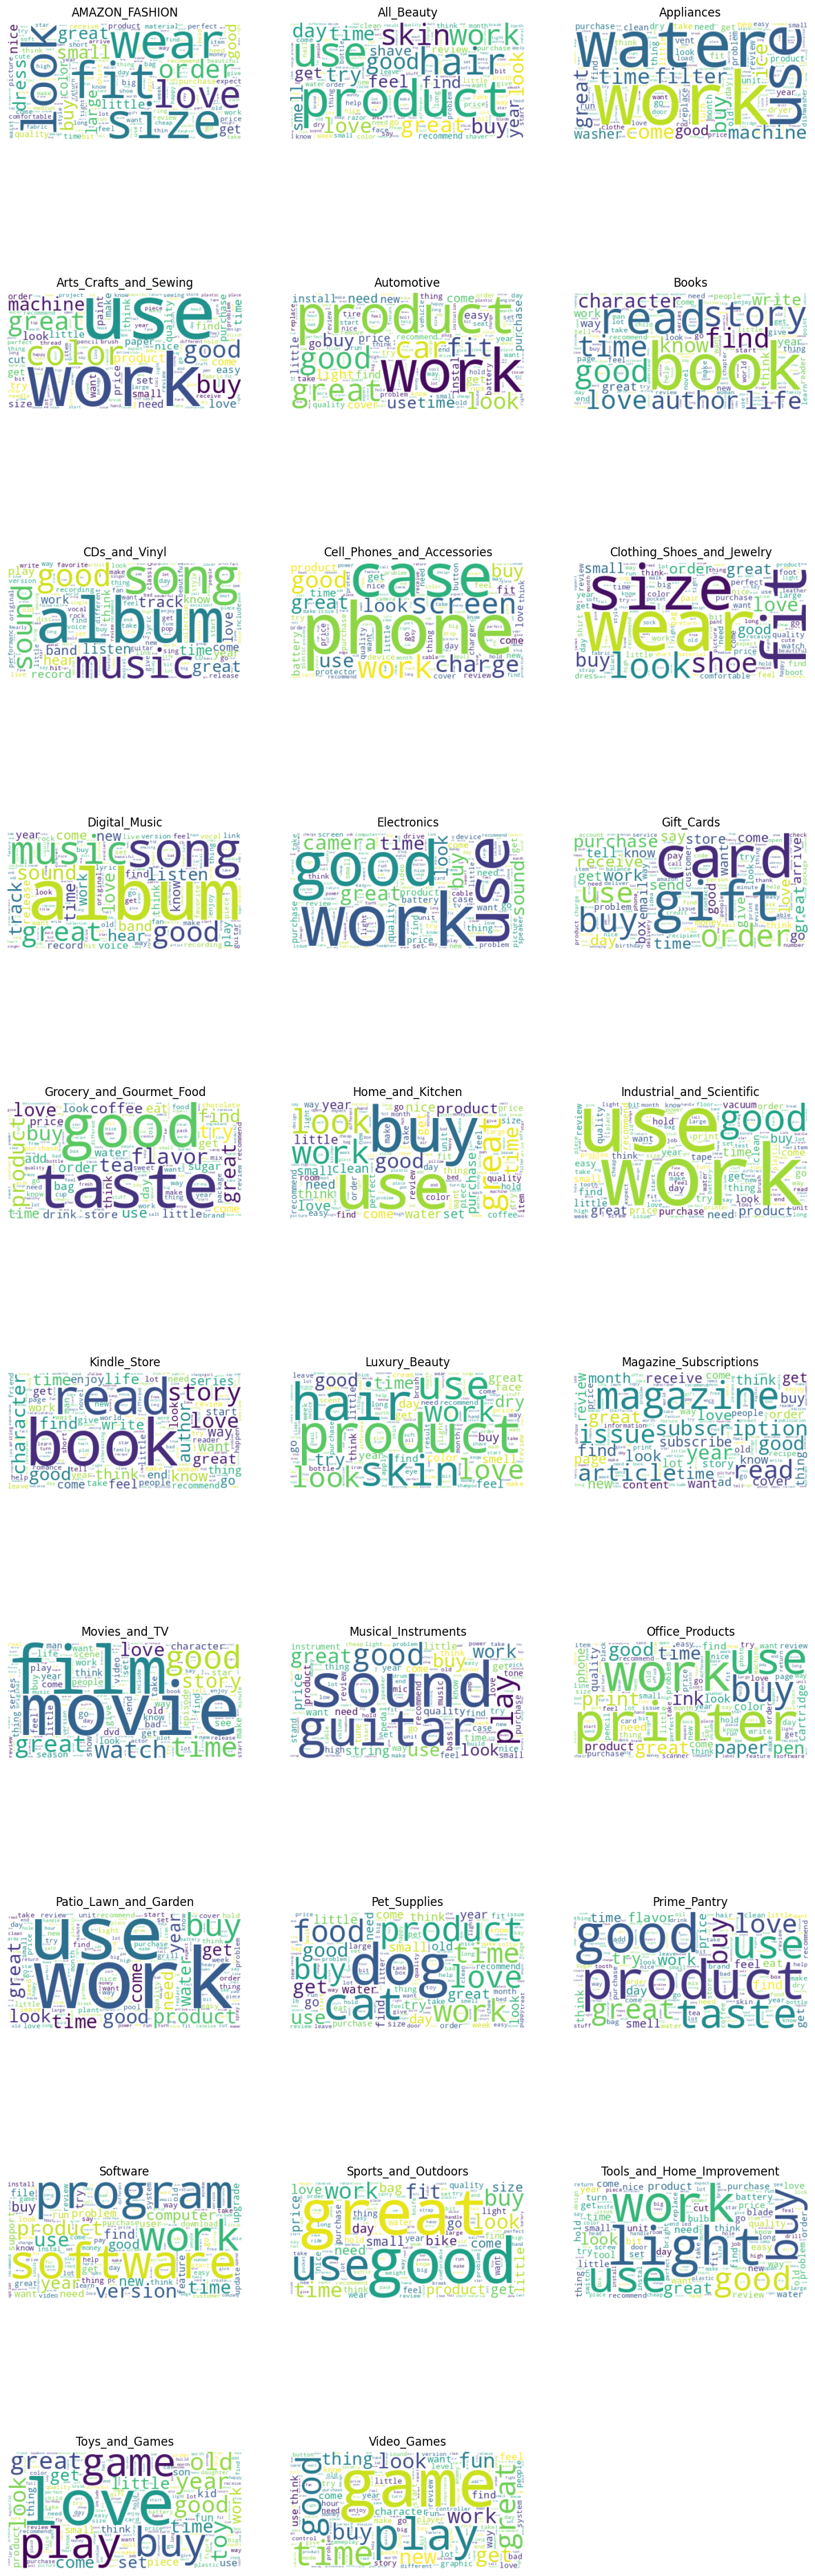

In [83]:
# Plot the WordCloud images for each category
categories = list(word_counts_by_category.keys())
num_categories = len(categories)
plots_per_row = 3
num_rows = (num_categories + plots_per_row - 1) // plots_per_row  # Ceiling division to calculate rows

fig, axs = plt.subplots(num_rows, plots_per_row, figsize=(15, 5*num_rows))

for i in range(num_rows):
    for j in range(plots_per_row):
        index = i * plots_per_row + j
        if index < num_categories:
            category = categories[index]
            word_counter = word_counts_by_category[category]

            wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(word_counts_by_category[category])

            axs[i, j].imshow(wordcloud, interpolation='bilinear')
            axs[i, j].set_title(category)
            axs[i, j].axis('off')
        else:
            # remove unused plots
            fig.delaxes(axs[i, j])

plt.show()

## Name Entity Recognition
NER shall help to identify and classify entities within the reviews by certain categories, to enhance our understanding of the mentioned aspects.
For evaluation, the proportion of referenced entities within each product category is estimated. The spaCy library is used, which has built-in recognition that encompasses 18 different entities. To inspect all possible labels, use the following code:
`nlp.get_pipe("ner").labels`

In [5]:
entitiy_proportions = pd.DataFrame()

for category, word_counter in word_counts_by_category.items():
    entity_label_counter = Counter()
    
    # Iterate through each word and count in the word counter
    for word, count in word_counter.items():
        doc = nlp(word)
        entities = [ent.label_ for ent in doc.ents]

        # Update entity_label_counter 
        entity_label_counter.update({entity: count for entity in entities})
    
    # Compute and store entity proportions
    sum_of_label_counts = sum(entity_label_counter.values())
    normalized_label_counts = {key: value / sum_of_label_counts for key, value in entity_label_counter.items()}

    # Create a DataFrame for the current category
    df_normalized_label_counts_by_category = pd.DataFrame(list(normalized_label_counts.items()), columns=['Entity Label', 'Normalized Count'])
    df_normalized_label_counts_by_category["category"] = category

    # Concatenate the current category DataFrame to entitiy_proportions
    entitiy_proportions = pd.concat([entitiy_proportions, df_normalized_label_counts_by_category], ignore_index=True)


stacked_df = entitiy_proportions.pivot(index='category', columns='Entity Label', values='Normalized Count')


In [94]:
stacked_df = stacked_df.fillna(0)
display(stacked_df)

Entity Label,CARDINAL,DATE,EVENT,FAC,GPE,LANGUAGE,LAW,LOC,MONEY,NORP,ORDINAL,ORG,PERSON,PRODUCT,TIME,WORK_OF_ART
category,,,,,,,,,,,,,,,,
AMAZON_FASHION,0.121294,0.169811,0.000000,0.000000,0.029650,0.000000,0.000000,0.013477,0.000000,0.102426,0.086253,0.210243,0.177898,0.005391,0.083558,0.000000
All_Beauty,0.080868,0.136095,0.000000,0.000000,0.027613,0.000000,0.000000,0.007890,0.000000,0.108481,0.084813,0.216963,0.165680,0.017751,0.149901,0.003945
Appliances,0.104167,0.111842,0.000000,0.000000,0.019737,0.000000,0.000000,0.001096,0.000000,0.018640,0.138158,0.145833,0.399123,0.002193,0.059211,0.000000
Arts_Crafts_and_Sewing,0.119191,0.085198,0.000000,0.000000,0.035714,0.001721,0.000000,0.017212,0.000000,0.064974,0.107573,0.314974,0.198795,0.008176,0.042169,0.004303
Automotive,0.091825,0.117332,0.000255,0.000128,0.029333,0.001530,0.000000,0.004719,0.000000,0.039153,0.119117,0.234026,0.263614,0.028823,0.068614,0.001530
Books,0.053467,0.102997,0.000257,0.000536,0.030781,0.015053,0.000059,0.022119,0.000000,0.290837,0.121671,0.167344,0.123118,0.012771,0.052460,0.006530
CDs_and_Vinyl,0.048541,0.089954,0.000174,0.000974,0.038318,0.013213,0.000000,0.013735,0.000000,0.171738,0.167391,0.193679,0.181439,0.009840,0.057443,0.013561
Cell_Phones_and_Accessories,0.081979,0.100777,0.000141,0.000707,0.023322,0.002261,0.000000,0.010318,0.000000,0.028551,0.129611,0.333710,0.211166,0.014700,0.061201,0.001555
Clothing_Shoes_and_Jewelry,0.129743,0.195869,0.000090,0.000358,0.026433,0.002195,0.000000,0.015008,0.000000,0.051387,0.123426,0.233950,0.135075,0.006183,0.076744,0.003539


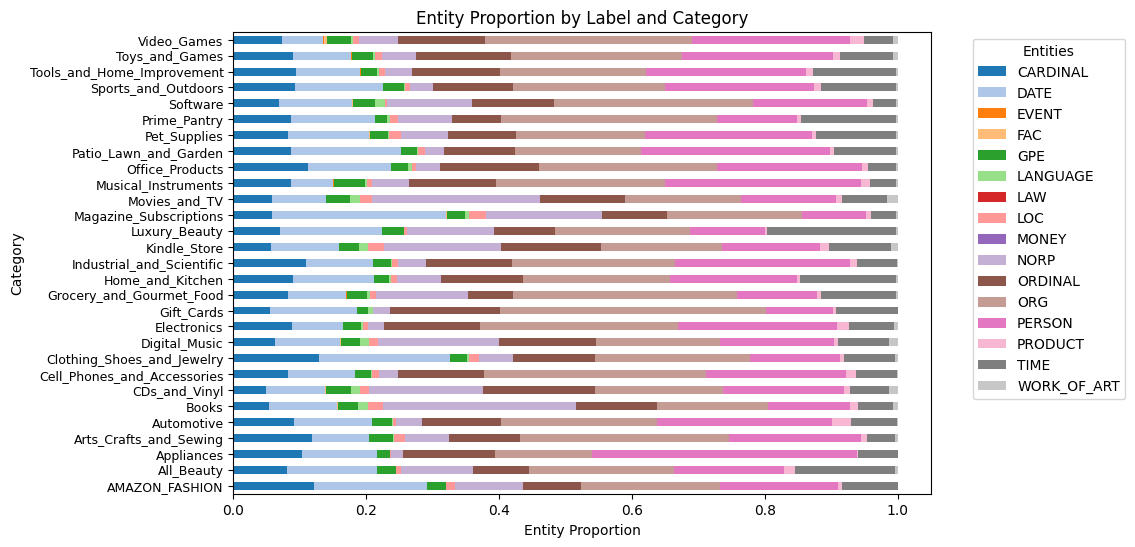

In [93]:
stacked_df = stacked_df.sort_index(ascending=True)

sns.set_palette("tab20")
ax = stacked_df.plot(kind='barh', stacked=True, figsize=(9,6))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Entities')
plt.title('Entity Proportion by Label and Category')
plt.xlabel("Entity Proportion")
plt.ylabel("Category")
plt.yticks(fontsize=9)
plt.show()

In [7]:
data = spark.read.parquet('/data/data.parquet', index_col=['reviewerID', 'asin'])
s = data.select("reviewText").filter(col("reviewText").contains("href")).take(5)
s

[Row(reviewText='I was so excited to get the new 3-in-1 Color Tool&nbsp;<a data-hook="product-link-linked" class="a-link-normal" href="/Ultimate-3-in-1-Color-Tool-24-Color-Cards-with-Numbered-Swatches-5-Color-Plans-for-each-Color-2-Value-Finders-Red-Green/dp/1607052350/ref=cm_cr_arp_d_rvw_txt?ie=UTF8">Ultimate 3-in-1 Color Tool: -- 24 Color Cards with Numbered Swatches -- 5 Color Plans for each Color -- 2 Value Finders Red & Green</a>&nbsp;to see what changes Joen Wolfrom had made from the original.  I was extremely pleased to see that she\'d put on the front of each color card the very things I had to keep turning the old one over to see - the color plans that make the tool so unique.  So now I can quickly turn to a color that I want in my quilt (or even what I\'m planning to wear that day!) and see which colors are going to make my choice of color work together for a successful project.  And she\'s also expanded the tints, tones and shades for each color on the back.  Although I don\

In [8]:
outlier_df = pd.DataFrame(s)
display(outlier_df)

,0
0,I was so excited to get the new 3-in-1 Color T...
1,and I molded a custom handle out of Sugru&nbsp...
2,"I already had two quilting rulers, a 6x24 and ..."
3,I believed it would work in my machine. It has...
4,If you use these decorative scissors on 80 lb....
